# Question 1.1

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [384]:
df = pd.read_csv('./A1_co2.txt', sep=' ')
df.head()

,year,month,time,co2
0,1958,3,1958.208,315.71
1,1958,4,1958.292,317.45
2,1958,5,1958.375,317.50
3,1958,6,1958.458,317.10
4,1958,7,1958.542,315.86


> You should not use the observations for years 2018 and 2019 (Last 20 observations) for estimations/training - only for comparisons/testing.

In [385]:
# Let the train set be the measurements before 2018, and the test set be the measurements after 2018
train = df[df['year'] < 2018]
test = df[df['year'] >= 2018]

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/915935225.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


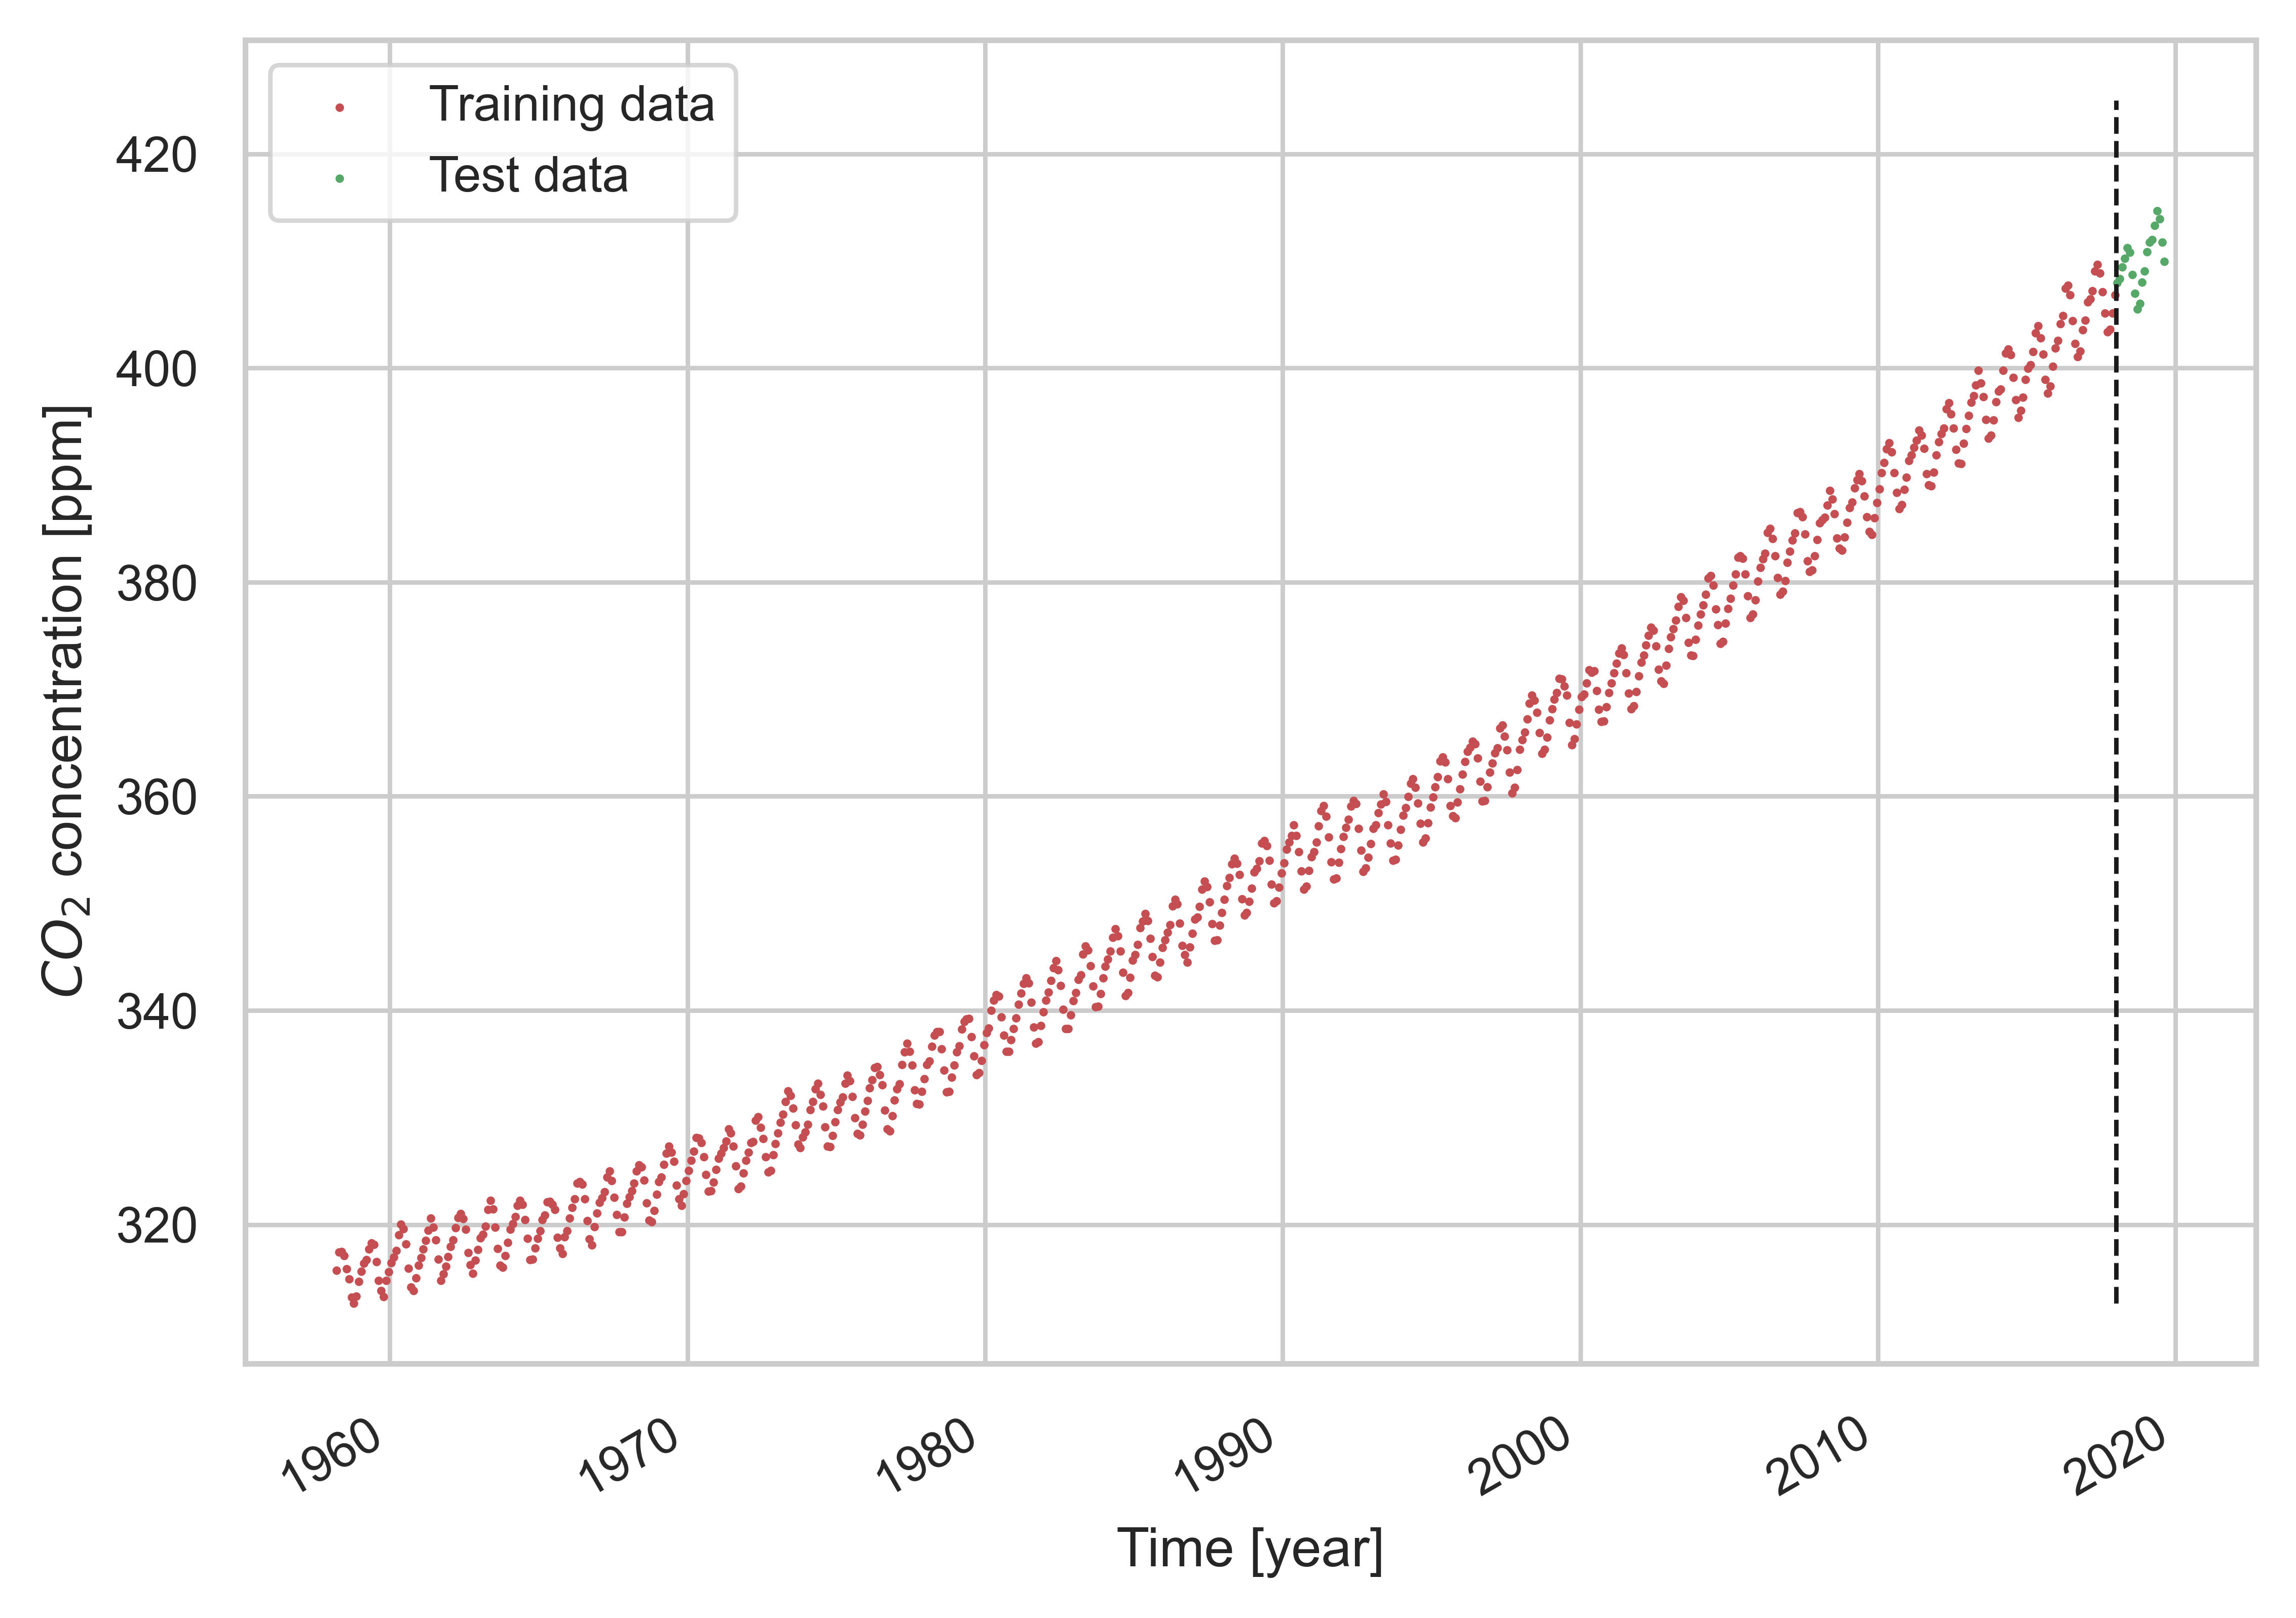

In [426]:
# Plot the data
fig, ax = plt.subplots(dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

ax.scatter(train["time"], train["co2"], label="Training data", s=0.5, c="r")
ax.scatter(test["time"], test["co2"], label="Test data", s=0.5, c="g")

ax.vlines(2018, train["co2"].min(), 425, linestyles="dashed", colors="k")

ax.legend()

ax.set_xlabel("Time [year]")
ax.set_ylabel("$CO_2$ concentration [ppm]")

fig.autofmt_xdate()
fig.show()

# Question 1.2

## Question 1.2.1

In [387]:
MONTHS_IN_YEAR = 12

X_train = np.vstack(
    [
        np.ones_like(train.index),
        train.index,
        np.sin(2 * np.pi / MONTHS_IN_YEAR * train.index),
        np.cos(2 * np.pi / MONTHS_IN_YEAR * train.index),
    ]
).T

In [388]:
y = train["co2"].values

In [389]:
beta_ols, _, _, _ = np.linalg.lstsq(X_train, y)
beta_ols

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/337856925.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_ols, _, _, _ = np.linalg.lstsq(X_train, y)


array([3.06928362e+02, 1.28374044e-01, 1.69090265e+00, 2.25306869e+00])

## Question 1.2.2

In [390]:
N, p = X_train.shape

residuals = y - X_train @ beta_ols

sigma_ols2 = np.sum(residuals ** 2) / (N - p)
sigma_ols2

12.185026694430931

In [391]:
sigma_ols = np.sqrt(sigma_ols2)
sigma_ols

3.490705758787316

In [392]:
var_beta_ols = sigma_ols2 * np.linalg.inv(X_train.T @ X_train)
var_beta_ols

array([[ 6.77484239e-02, -1.41638461e-04, -4.00049374e-04,
        -2.70584607e-04],
       [-1.41638461e-04,  3.95086363e-07,  9.35333307e-07,
         9.35333307e-07],
       [-4.00049374e-04,  9.35333307e-07,  3.39442373e-02,
        -7.99112497e-05],
       [-2.70584607e-04,  9.35333307e-07, -7.99112497e-05,
         3.39442373e-02]])

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/3628586960.py:2: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(var_beta_ols), annot=True, fmt=".2f")


<AxesSubplot: >

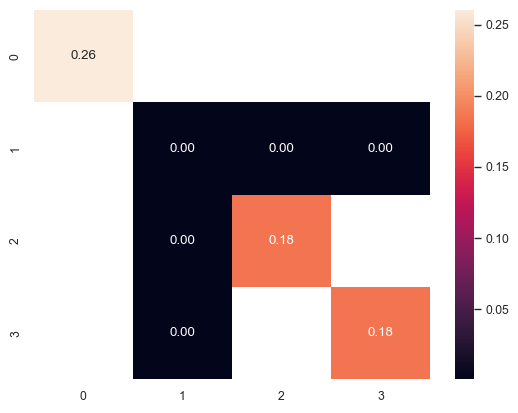

In [393]:
# Heatmap of the variance of the coefficients
sns.heatmap(np.sqrt(var_beta_ols), annot=True, fmt=".2f")

In [394]:
np.sqrt(np.diag(var_beta_ols))

array([0.26028527, 0.00062856, 0.18423962, 0.18423962])

## Question 1.2.3

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/2400270314.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


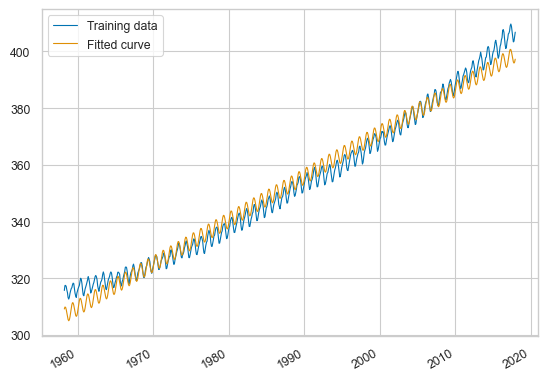

In [395]:
y_hat = X_train @ beta_ols

# Plot the train set and the fitted curve
fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], label="Training data")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()

## Question 1.2.4

Plan-of-attack: Relaxtion algorithm

In [396]:
def rho_matrix(rho: float, n: int):
    """
    Returns the covariance matrix for the observations of a stationary AR(1) process.
    """
    rhos = np.vander([rho], n, increasing=True)
    return scipy.linalg.toeplitz(rhos)


N, p = X_train.shape

# Initial guess of correlation structure
Sigma_wls = np.eye(N)

# Initial guess of coefficients
beta_wls = beta_ols

betas_wls = []

for _ in range(6):
    # E-step
    Sigma_inv = np.linalg.inv(Sigma_wls)

    H = np.linalg.inv(X_train.T @ Sigma_inv @ X_train) @ X_train.T @ Sigma_inv

    beta_new = H @ y

    # M-step
    residuals = y - X_train @ beta_new

    rho = np.corrcoef(residuals[:-1], residuals[1:])[0, 1] # 1-lag autocorrelation
    print(rho)

    Sigma_new = rho_matrix(rho, N)

    #if np.allclose(beta, beta_new, atol=1e-6) and np.allclose(Sigma, Sigma_new, atol=1e-6):
    #   break

    beta_wls = beta_new
    Sigma_wls = Sigma_new

    betas_wls.append(beta_wls)

beta_wls

0.9820921007263159
0.9822410526176385
0.9822427429486106
0.982242762307222
0.9822427625289551
0.9822427625314976


array([3.07470864e+02, 1.29839150e-01, 1.66890379e+00, 2.29457132e+00])

## Question 1.2.6

In [397]:
# Calculate the variance of the coefficients
sigma_wls2 = (residuals.T @ np.linalg.inv(Sigma_wls) @ residuals ) / (N - p)

var_beta_wls = np.linalg.inv(X_train.T @ np.linalg.inv(Sigma_wls) @ X_train) * sigma_wls2
var_beta_wls

array([[ 5.37440920e+00, -1.03811751e-02, -5.30015696e-04,
        -1.12349504e-03],
       [-1.03811751e-02,  2.89572528e-05,  2.30615165e-06,
         2.30615165e-06],
       [-5.30015696e-04,  2.30615165e-06,  4.57062027e-03,
         1.28481766e-05],
       [-1.12349504e-03,  2.30615165e-06,  1.28481766e-05,
         4.57062027e-03]])

In [427]:
sigma_wls2

12.268130156533738

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/1372562171.py:1: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(var_beta_wls), annot=True, fmt=".2f")


<AxesSubplot: >

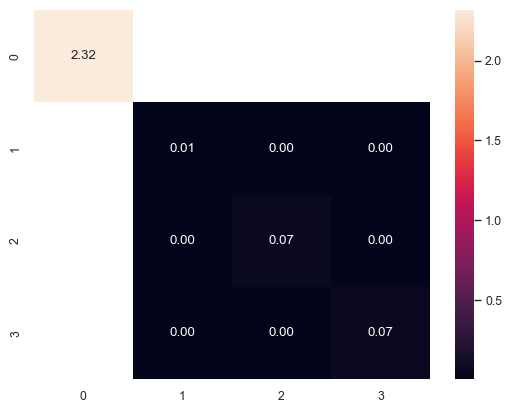

In [398]:
sns.heatmap(np.sqrt(var_beta_wls), annot=True, fmt=".2f")

In [399]:
np.sqrt(np.diag(var_beta_wls))

array([2.3182772 , 0.00538119, 0.06760636, 0.06760636])

In [400]:
beta_ols - beta_wls

array([-0.54250225, -0.00146511,  0.02199886, -0.04150264])

## Model comparison plot

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/2657896924.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


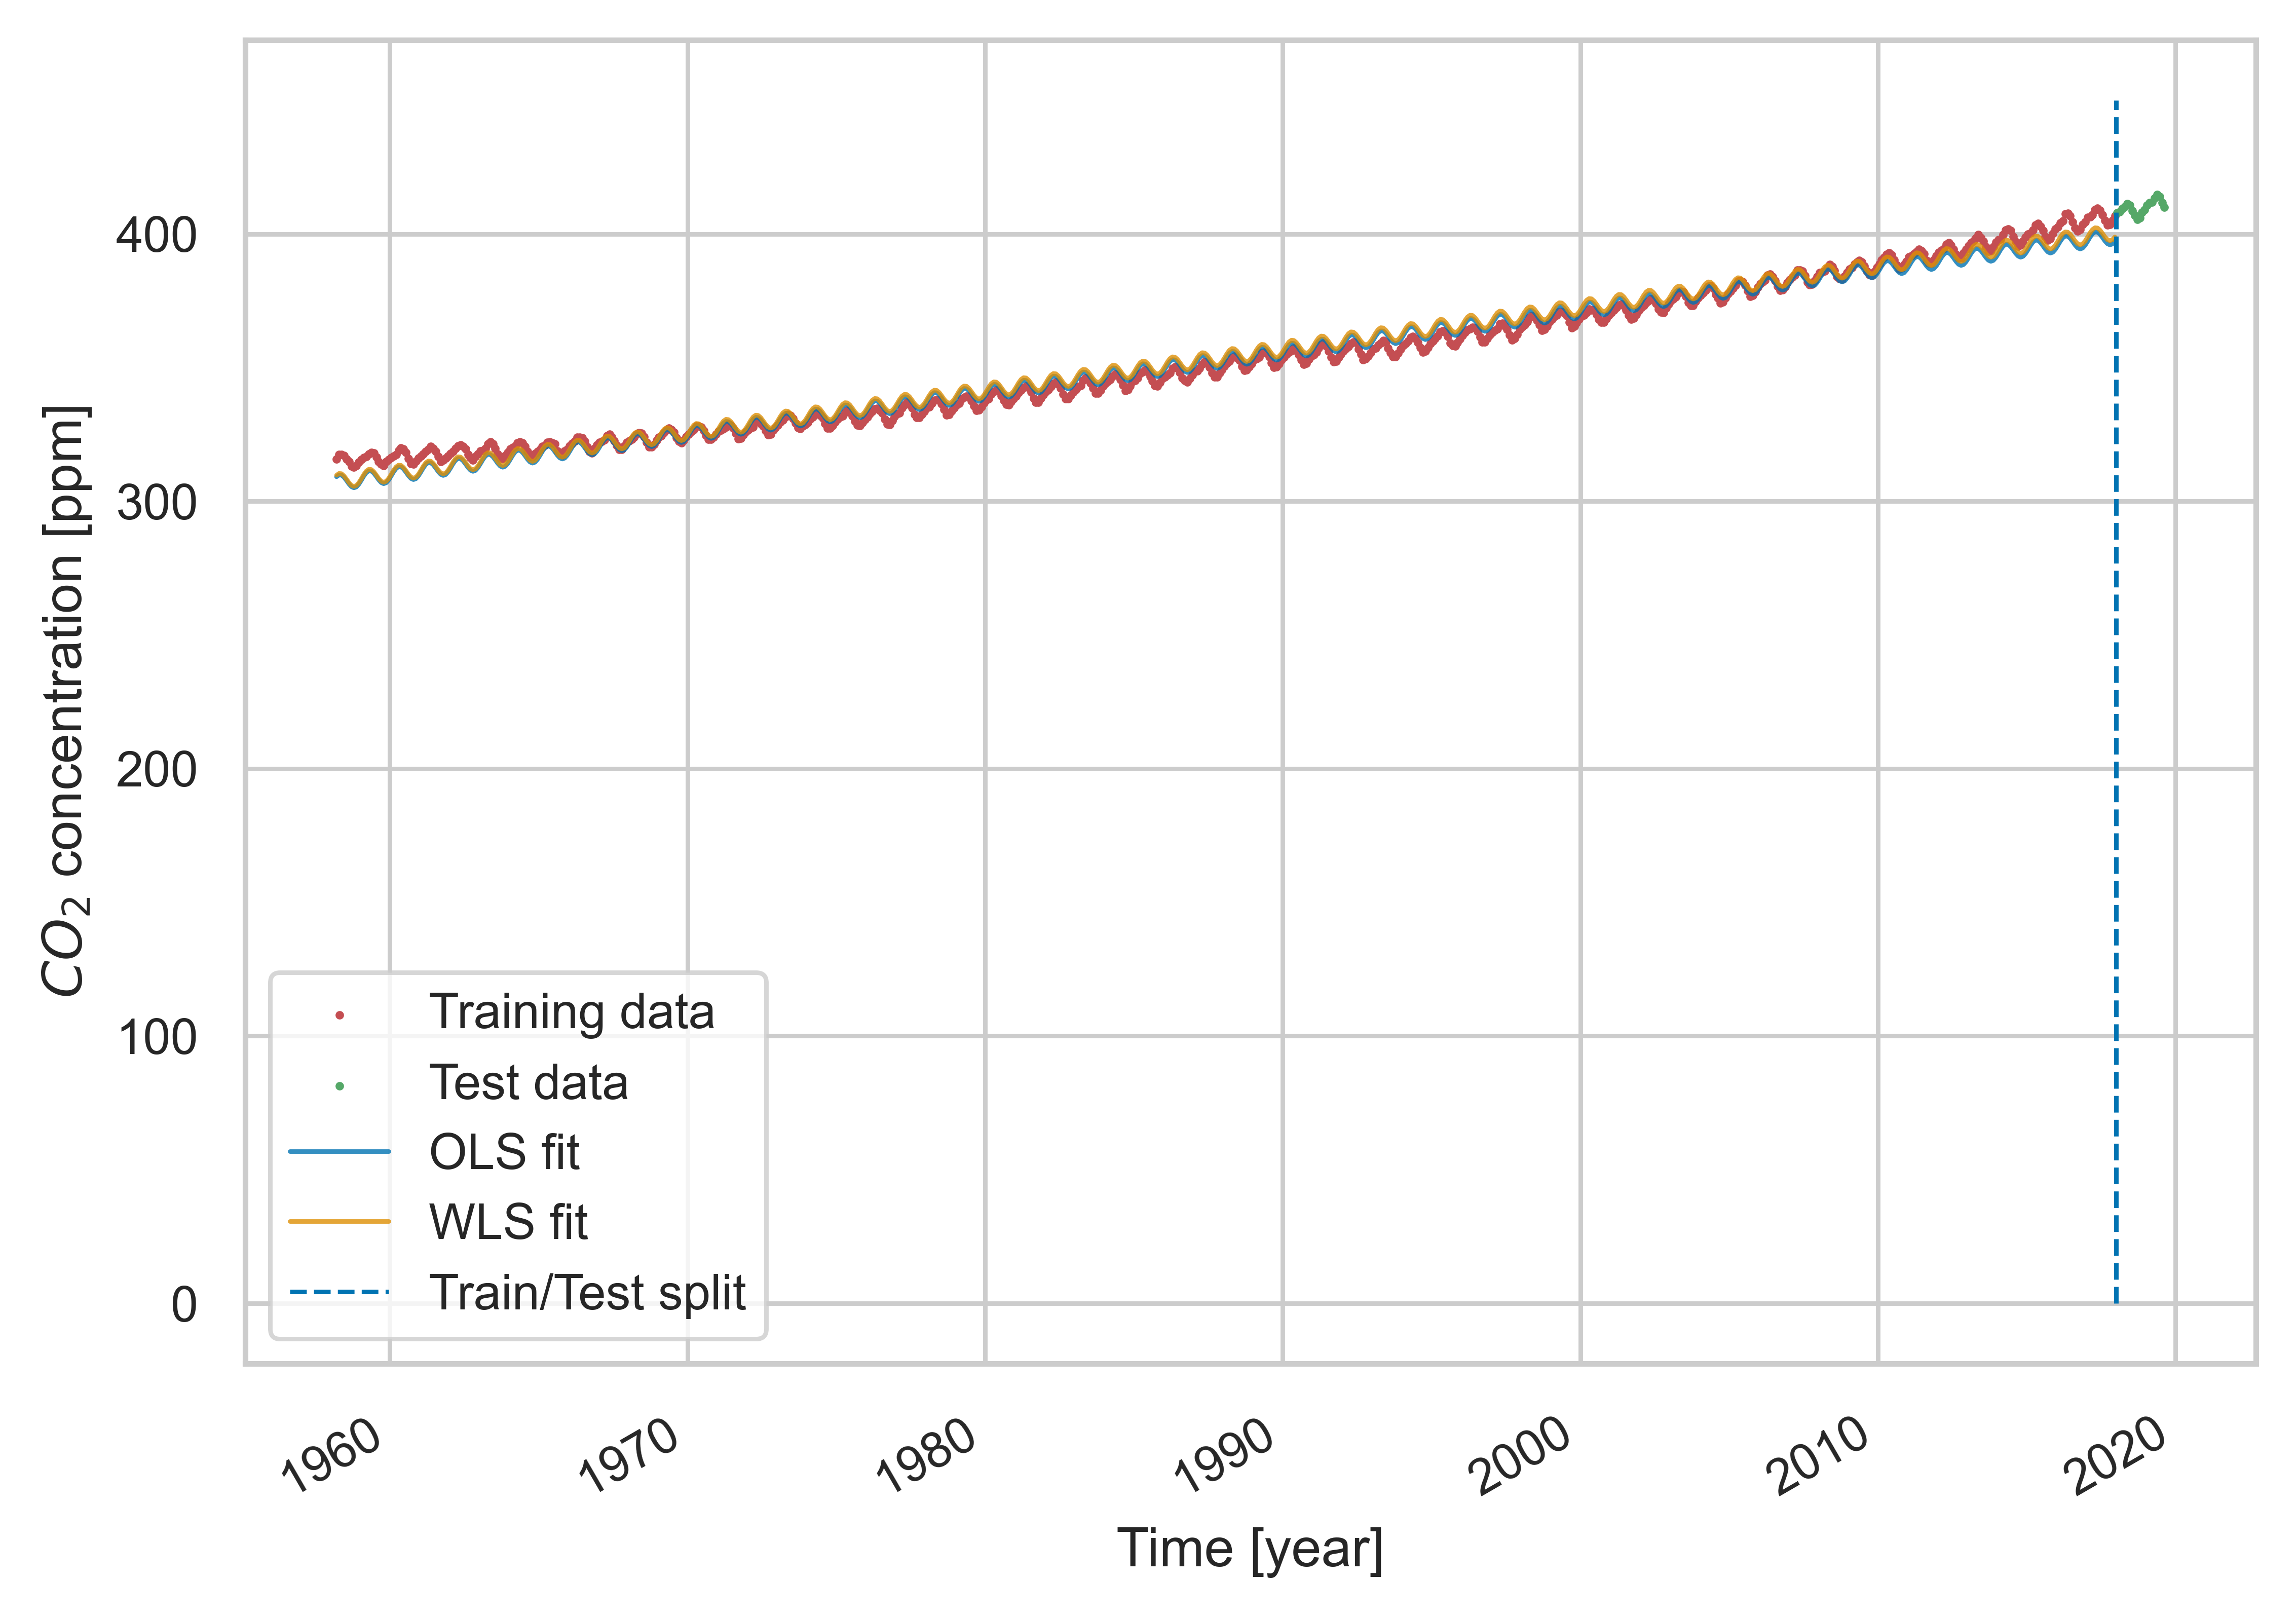

In [423]:
y_hat_ols = X_train @ beta_ols
y_hat_wls = X_train @ beta_wls

# Plot the train set and the fitted curves
fig, ax = plt.subplots(dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

ax.scatter(train["time"], train["co2"], label="Training data", s=0.5, c="r")
ax.scatter(test["time"], test["co2"], label="Test data", s=0.5, c="g")
ax.plot(train["time"], y_hat_ols, label="OLS fit", alpha=0.8)
ax.plot(train["time"], y_hat_wls, label="WLS fit", alpha=0.8)

ax.vlines(2018, 0, 450, linestyles="dashed", label="Train/Test split")
ax.legend()


ax.set_xlabel("Time [year]")
ax.set_ylabel("$CO_2$ concentration [ppm]")

fig.autofmt_xdate()
fig.show()

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/3346189001.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


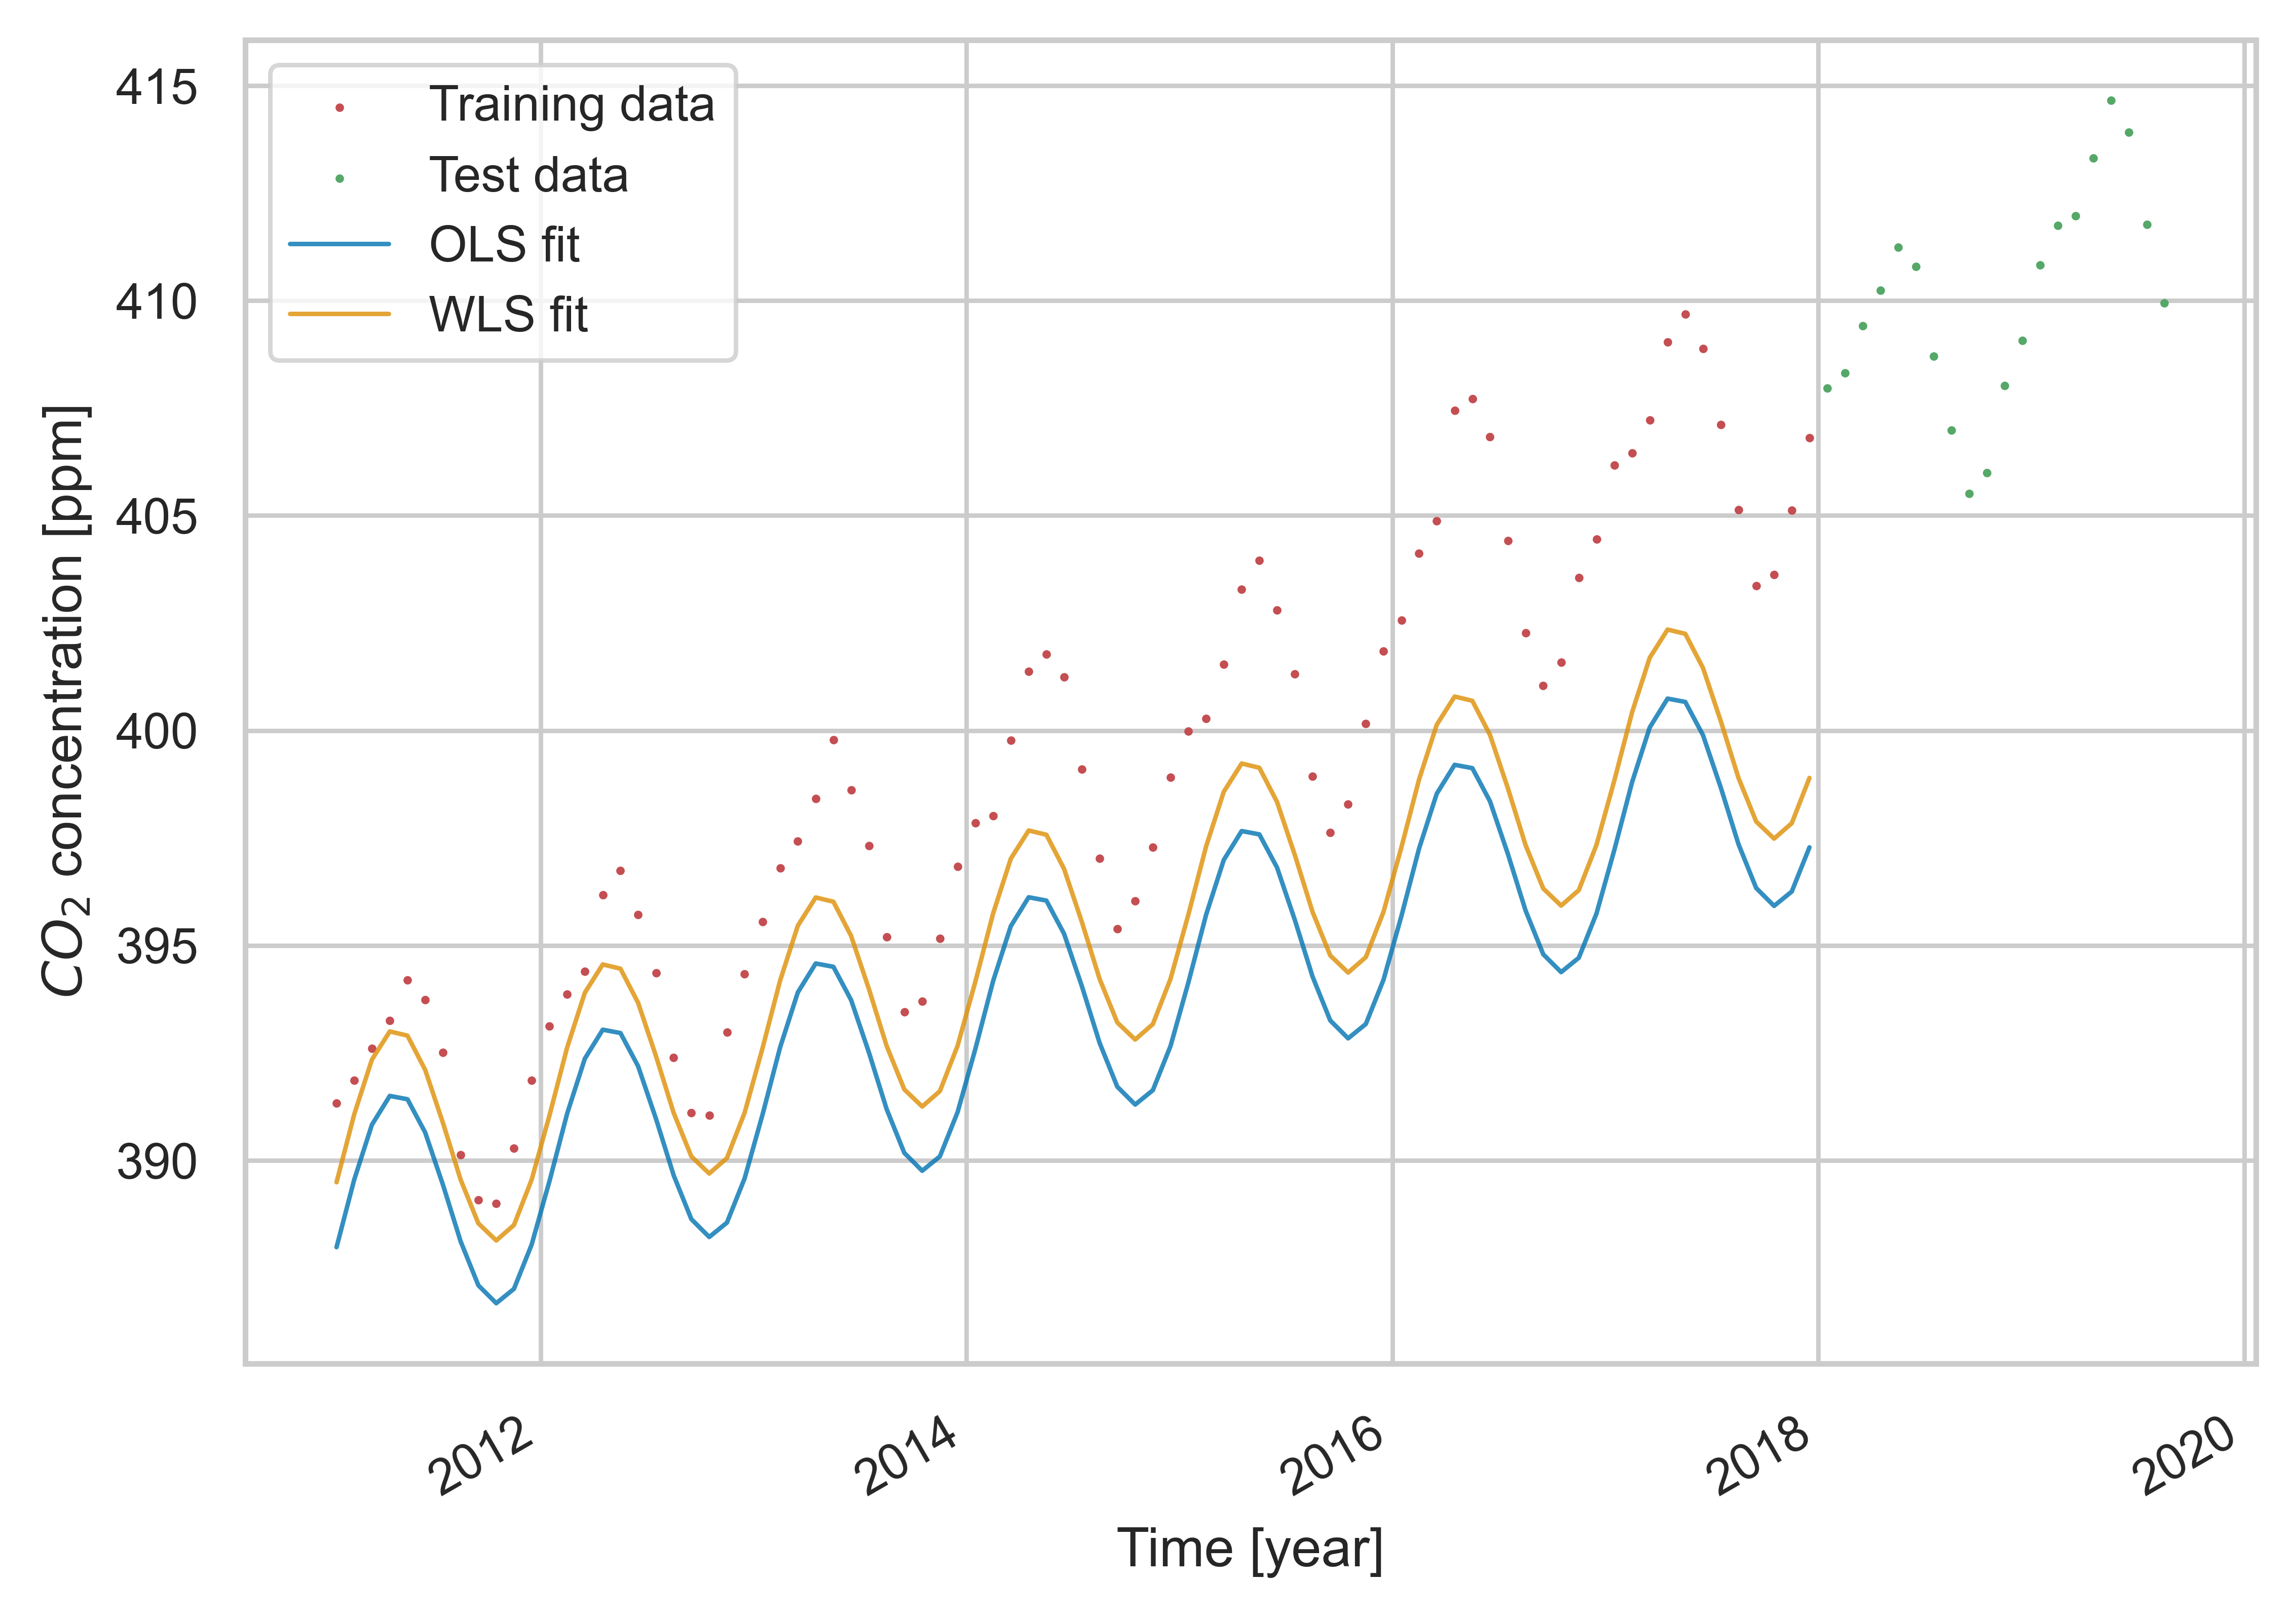

In [421]:
y_hat_ols = X_train @ beta_ols
y_hat_wls = X_train @ beta_wls

# Plot the train set and the fitted curves
fig, ax = plt.subplots(dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

idx_2010 = train["year"] > 2010

ax.scatter(train["time"][idx_2010], train["co2"][idx_2010], label="Training data", s=0.5, c="r")
ax.scatter(test["time"], test["co2"], label="Test data", s=0.5, c="g")
ax.plot(train["time"][idx_2010], y_hat_ols[idx_2010], label="OLS fit", alpha=0.8)
ax.plot(train["time"][idx_2010], y_hat_wls[idx_2010], label="WLS fit", alpha=0.8)

ax.vlines(test["time"][0], 0, 500, linestyles="dashed", label="Test set start")

ax.legend()

ax.set_xlabel("Time [year]")
ax.set_ylabel("$CO_2$ concentration [ppm]")

fig.autofmt_xdate()
fig.show()

## Model comparison 

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/1468191774.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


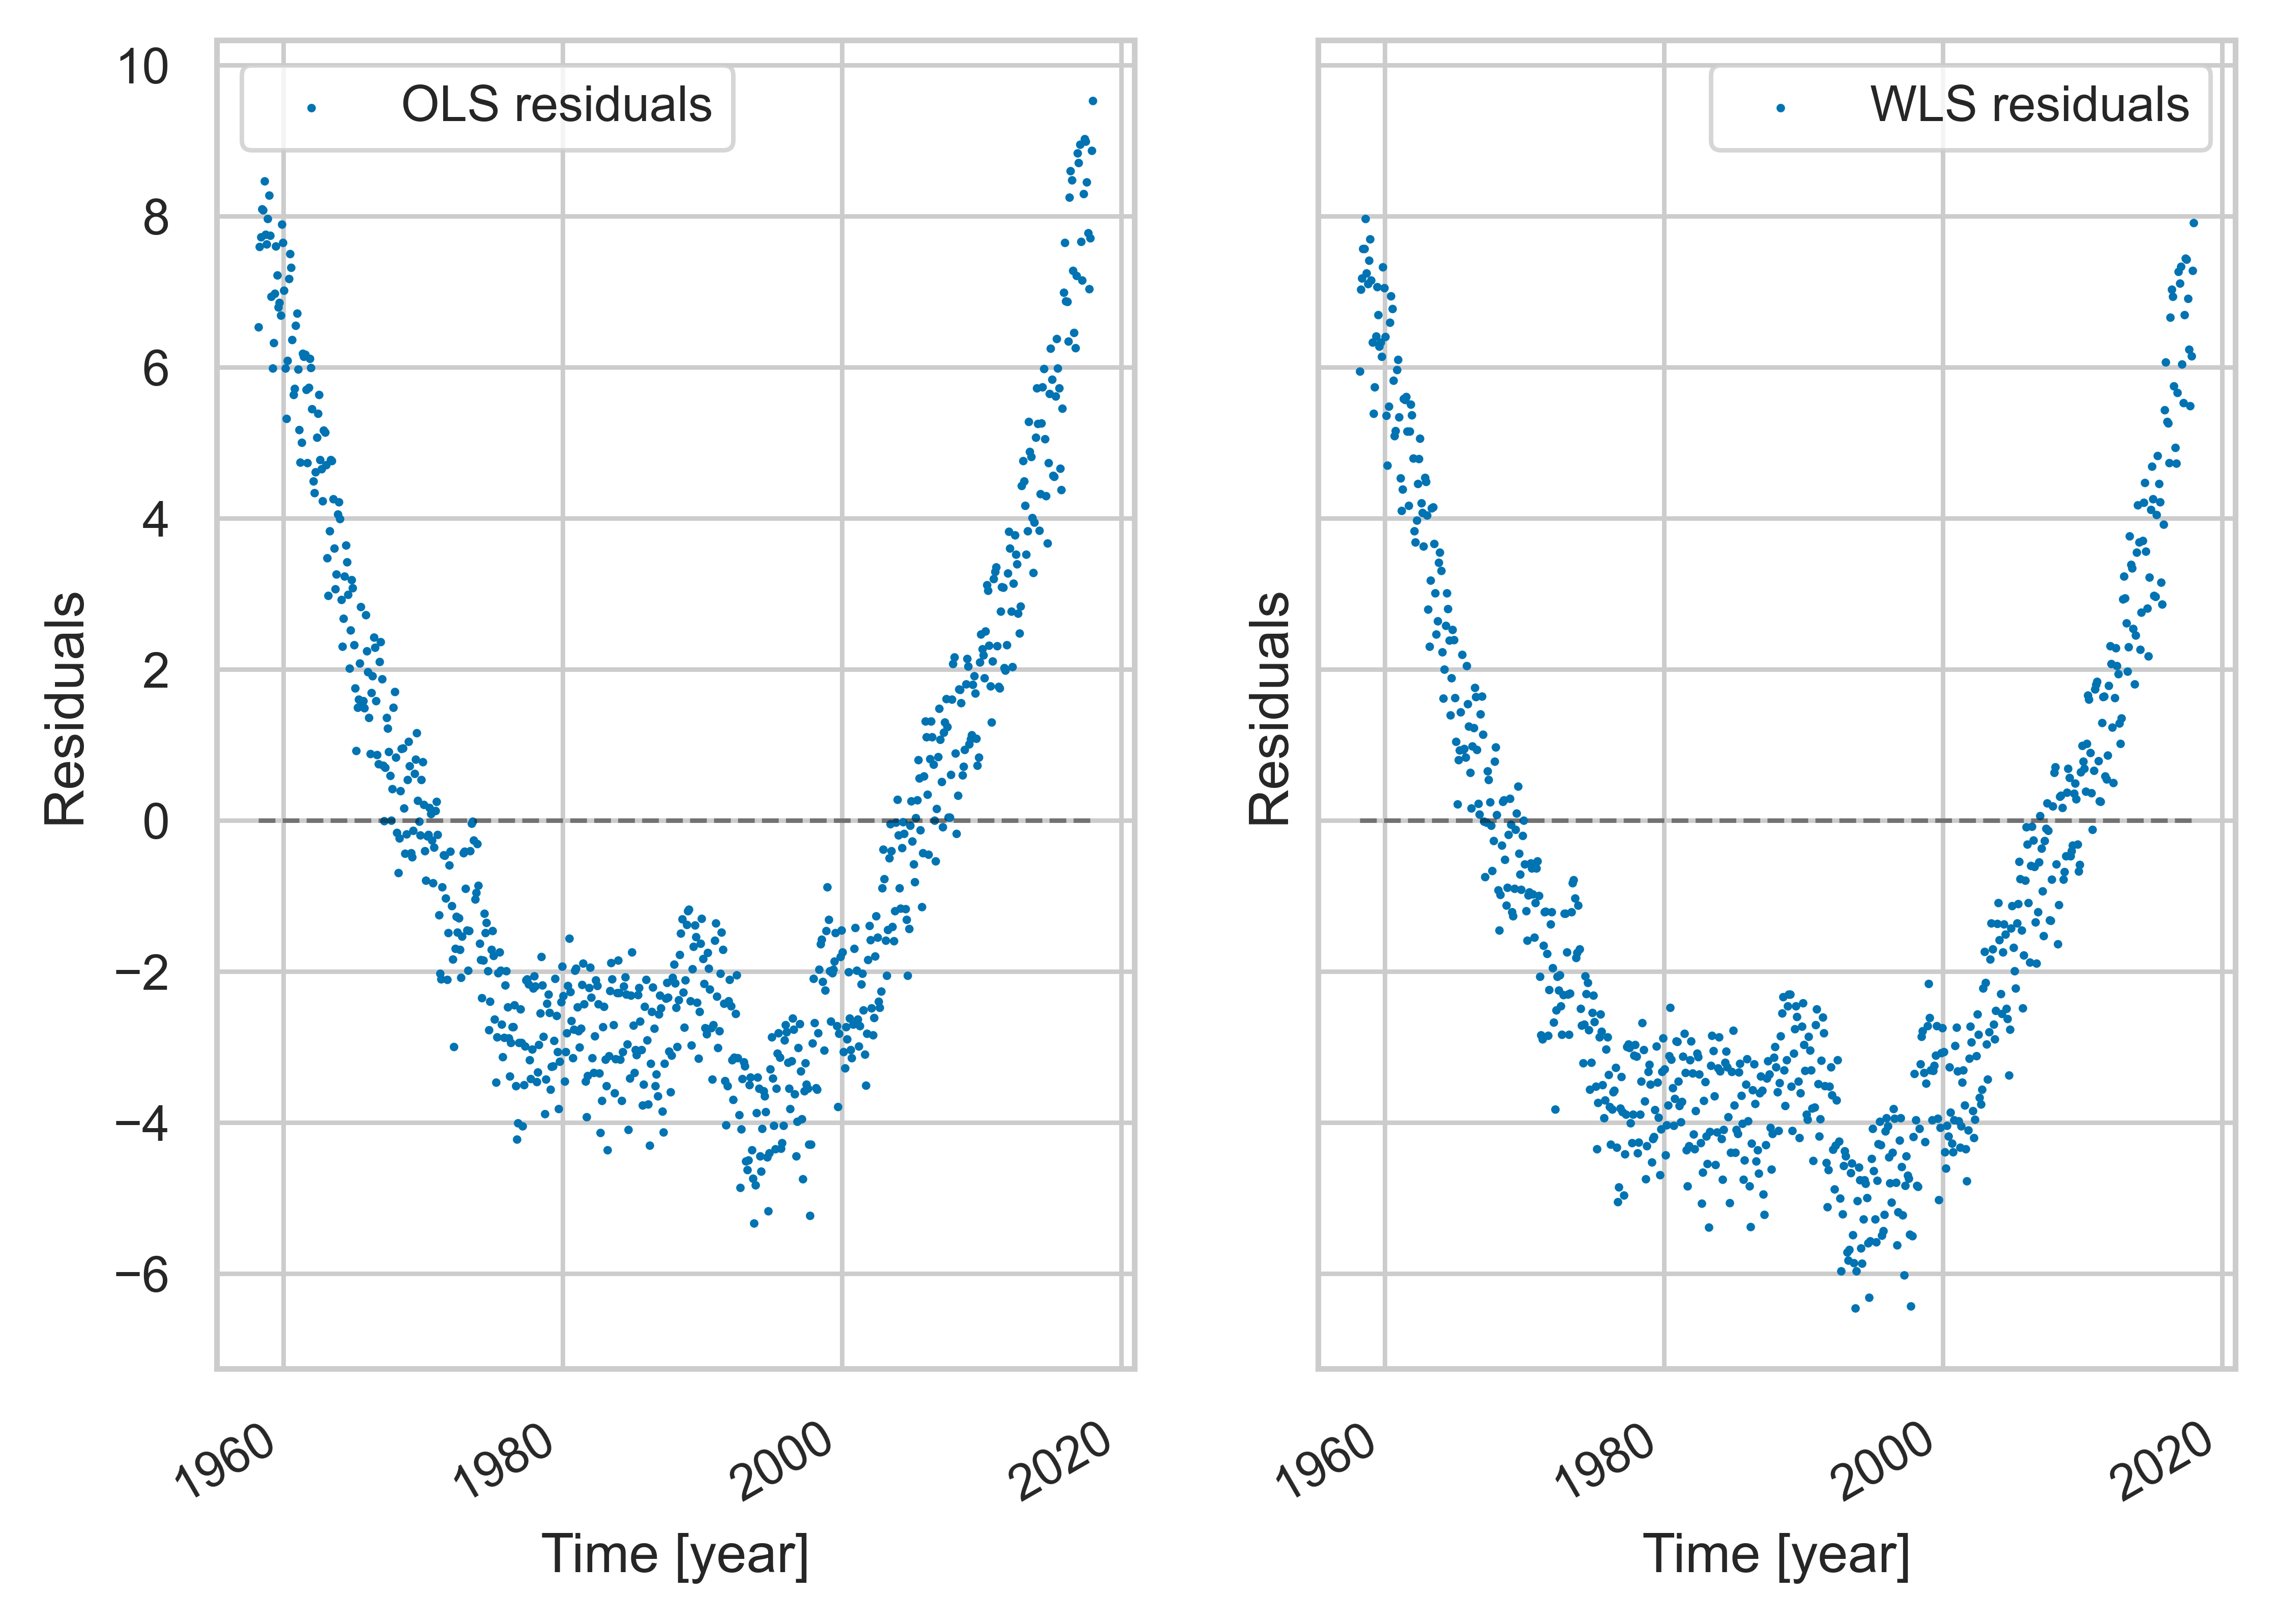

In [419]:
residuals_ols = train["co2"] - y_hat_ols
residuals_wls = train["co2"] - y_hat_wls

# Scatter plot of the residuals for the OLS and WLS fits
fig, ax = plt.subplots(ncols=2, sharey=True, dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

ax[0].scatter(train["time"], residuals_ols, label="OLS residuals", s=0.5,)
ax[1].scatter(train["time"], residuals_wls, label="WLS residuals", s=0.5)

ax[0].hlines(0, train["time"].min(), train["time"].max(), linestyle="--", alpha=0.5, colors="k")
ax[1].hlines(0, train["time"].min(), train["time"].max(), linestyle="--", alpha=0.5, colors="k")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("Time [year]")
ax[1].set_xlabel("Time [year]")

ax[0].set_ylabel("Residuals")
ax[1].set_ylabel("Residuals")

fig.autofmt_xdate()
fig.show()

# Question 1.3
## Question 1.3.1

See derivation on paper

## Question 1.3.2

Filter the data with the chosen model.

In [403]:
lambda_ = 0.9

In [404]:
N, p

(718, 4)

In [405]:
def f(js):
    return np.vstack(
        [
            np.ones_like(js),
            js,
            np.sin(2 * np.pi / MONTHS_IN_YEAR * js),
            np.cos(2 * np.pi / MONTHS_IN_YEAR * js),
        ]
    )

In [406]:
L = np.array(
    [
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 0, np.cos(2 * np.pi / MONTHS_IN_YEAR), np.sin(2 * np.pi / MONTHS_IN_YEAR)],
        [0, 0, -np.sin(2 * np.pi / MONTHS_IN_YEAR), np.cos(2 * np.pi / MONTHS_IN_YEAR)],
    ]
)

L_inv = np.linalg.inv(L)

In [407]:
N, p = X_train.shape

y_train = train["co2"].values
y_filtered = np.zeros_like(y_train)

f_0 = f(0)
f_1 = f(1)

BURN_IN = 10

# Initial filter parameters
F_i = np.zeros((p, p))
h_i = np.zeros((p, 1))
thetas = np.zeros((N, p))
sigmas = np.zeros(N)

y_pred = np.zeros(N)
one_step_variance = np.zeros(N)

# Burn in
for i in range(BURN_IN):
    F_i = F_i + lambda_**i * f(-i) @ f(-i).T
    h_i = lambda_ * L_inv @ h_i + f_0 * y_train[i]

# Iterative filtering
for i in range(BURN_IN, N-1):
    # Update the filter parameters
    F_i = F_i + lambda_**i * f(-i) @ f(-i).T

    h_i = lambda_ * L_inv @ h_i + f_0 * y_train[i]

    theta_i = np.linalg.inv(F_i) @ h_i

    thetas[i] = theta_i.flatten()

    # Filtered value
    y_filtered[i] = f_0.T @ theta_i
    y_pred[i] = f_1.T @ theta_i
    
    # Variance of the one-step prediction,
    # See Lasses lecture 4, part D
    one_step_variance[i] = (y_train[i+1] - y_pred[i])**2 / (1 + f_1.T @ np.linalg.inv(F_i) @ f_1)


    sigmas[i] = np.sqrt(np.mean(one_step_variance[BURN_IN:i]))

/Users/volesen/miniconda3/envs/tsa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/volesen/miniconda3/envs/tsa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [408]:
sigmas[-2]

0.6274513469421232

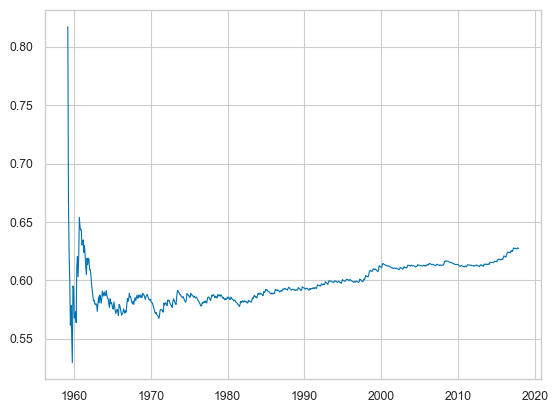

In [409]:
plt.plot(train["time"][BURN_IN+2:-1], sigmas[BURN_IN+2:-1], label="Residuals")

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_1479/2274238649.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


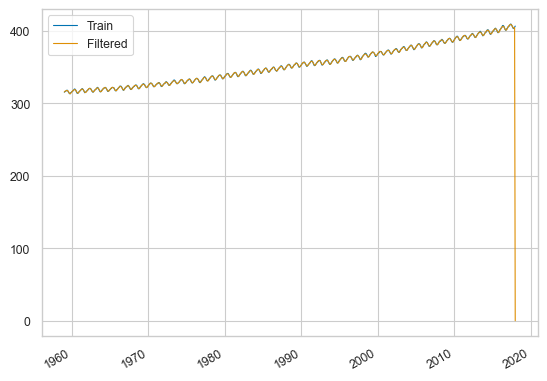

In [410]:
fig, ax = plt.subplots()

ax.plot(train["time"][BURN_IN:], train["co2"][BURN_IN:], label="Train")
ax.plot(train["time"][BURN_IN:], y_filtered[BURN_IN:], label="Filtered")
ax.legend()

fig.autofmt_xdate()
fig.show()

# Question 1.3.3

In [411]:
residuals = y_train[BURN_IN:] - y_filtered[BURN_IN:]


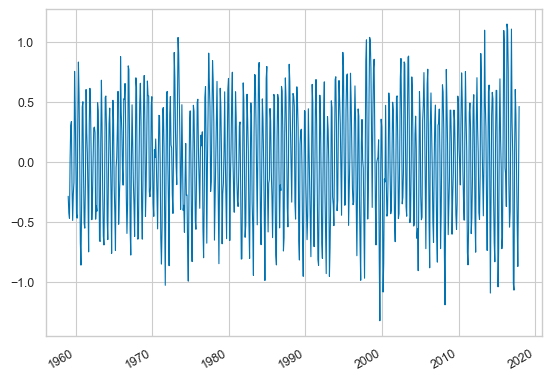

In [431]:
fig, ax = plt.subplots()

ax.plot(train["time"][BURN_IN:-1], residuals[:-1], label="Residuals")

fig.autofmt_xdate()


## Question 1.3.4

In [413]:
# Estimate the variance of the residuals
sigma_hat2 = np.sum(residuals ** 2) / (N - p)
sigma_hat2

232.03001978751686

In [414]:
sigma_hat = np.sqrt(sigma_hat2)
sigma_hat

15.232531627655229

In [415]:
import scipy.stats

ls = [1, 2, 6, 12, 24]

alpha = 0.05

y_hat = np.zeros(len(ls))
stds = np.zeros(len(ls))
lower_bound = np.zeros(len(ls))
upper_bound = np.zeros(len(ls))

# l-step prediction
for i, l in enumerate(ls):
    y_hat[i] = f(l).T @ theta_i

    var = sigma_hat2 * f(l).T @ np.linalg.inv(F_i) @ f(l) 

    stds[i] = np.sqrt(var)

    lower_bound[i] = y_hat[i] - scipy.stats.norm.ppf(1 - alpha) * np.sqrt(var)
    upper_bound[i] = y_hat[i] + scipy.stats.norm.ppf(1 - alpha) * np.sqrt(var)

In [416]:
predictions = pd.DataFrame(
    {
        "l": ls,
        "std": stds,
        "y_hat": y_hat,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
    }
)

predictions

,l,std,y_hat,lower_bound,upper_bound
0,1,10.462234,406.069035,388.860193,423.277878
1,2,11.951733,407.935735,388.276883,427.594587
2,6,12.826285,411.749550,390.652188,432.846912
3,12,13.124765,407.250334,385.662017,428.838651
4,24,18.581144,409.841976,379.278714,440.405238


In [ ]:
plt.plot()